In [1]:
% load_ext autoreload
% autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from pseudo import *
import numpy as np
import blasius
import matplotlib.pyplot as plt
import ops
import scipy as sp
%matplotlib inline

/home/sabarish/Dropbox/melb/code/library/ops.py:30: UserWarning: Code for boundary layers is not ready yet.. DO NOT TRUST THESE RESULTS.
  warn("Code for boundary layers is not ready yet.. DO NOT TRUST THESE RESULTS.")
/home/sabarish/Dropbox/melb/code/library/pseudo.py:507: UserWarning: Differentiation matrices for BLs only work on quantities that go to 0 as y -> inf.
  warn("Differentiation matrices for BLs only work on quantities that go to 0 as y -> inf.")


Eigenvalue solution returned with error norm: 5.68720834388e-11
(302,) (302, 302) (151,)


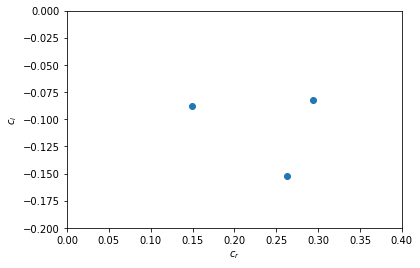

In [36]:
flowDict = {'a':1./1.72, 'b':0., 'Re':800./1.72}
#flowDict = {'a':0.2,'b':0., 'Re':500.}
N = 151
#y = chebdif(N+2,1)[0]
#y = y[1:-1]
#U = 1.- y**2; dU = -2.*y; d2U=-2.*np.ones(U.size)
#linOps = ops.linearize(N=N,flowClass="channel", U=U, dU=dU, d2U=d2U )
linOps = ops.linearize(N=N,flowClass="bl",Y=15.)

evals, evecs = linOps.eig(linOps.OSS(**flowDict), weighted=True)
#evals, evecs = linOps.eig(OSS, b=b, weighted=True)
print(evals.shape, evecs.shape, linOps.y.shape)

omega = -1.j*evals
c = omega/flowDict['a']
#c = omega
if True:
    plt.scatter(c.real, c.imag)
    plt.xlim([0.,0.4])
    plt.ylim([-0.2,0.])
    plt.xlabel("$c_r$"); plt.ylabel("$c_i$")
    plt.show()

In [37]:
c1 = c[0.<c.real]
c2 = c1[c1.real<0.8]
c3 = c2[-0.4< c2.imag]
c4 = c3[c3.imag< 0.]

#ind = np.arange(c.size)[boolInd]
#print(c4)
c = c4
if True:
    ind = np.argsort(-c.imag)
    cSort = c[ind]
    print(cSort[:20])
    #c = cSort

[ 0.29404424-0.08242276j  0.14992653-0.08786553j  0.26259680-0.1522347j
  0.46368696-0.16985164j  0.35536572-0.20404568j  0.58317471-0.21360701j
  0.23719315-0.2143714j   0.43809853-0.24861048j  0.66973366-0.2868408j
  0.51467298-0.28783762j  0.42142710-0.29550936j  0.76855006-0.29600468j
  0.71495947-0.3170096j   0.58720443-0.32261956j  0.65670779-0.35368605j
  0.57824546-0.35870288j  0.65345626-0.36560538j  0.72584214-0.37579287j]


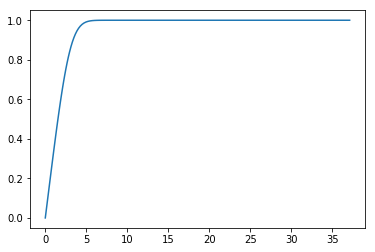

In [8]:
plt.plot(linOps.y, linOps.U)
plt.show()

In [9]:
# Testing the differentiation operator of BL
y = linOps.y
f   = (y**2)* np.exp(-y)
fy  = np.exp(-y)*(2.*y - y**2)
fy2 = np.exp(-y)*(2.-4.*y + y**2)
fy4 = np.exp(-y)*(12.-8.*y+y**2)

_fy  = np.dot(linOps.D1, f)
_fy2 = np.dot(linOps.D2, f)
_fy4 = np.dot(linOps.D4, f)


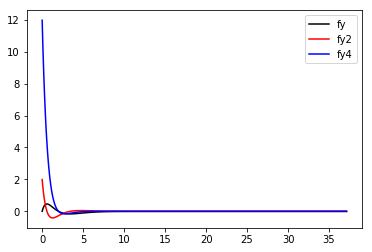

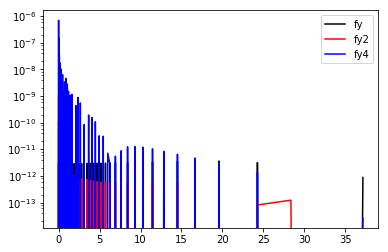

In [10]:
plt.plot(y, fy,'k', y, fy2,'r', y, fy4,'b')
#plt.yscale("log")
plt.legend(['fy','fy2','fy4'])
plt.show()

plt.figure()
plt.plot(y, fy-_fy,'k', y, fy2-_fy2,'r', y, fy4-_fy4,'b')
plt.yscale("log")
plt.legend(['fy','fy2','fy4'])
plt.show()

# Testing BL transformation code

## Calculating derivatives directly from channel diff mats

In [22]:
# There seem to be issues with the transformation. 
# For starters, let's see if the kinda functions that go 
#   into semi-infinite domains can be accurately differentiated in Cheb
N = 81; Y = 15
eta, DMch = chebdif(2*N+2,4)
DMchcl = cheb4c(2*N+2,returnAll=True)
eta = eta[1:N+1]
DMch = np.ascontiguousarray(DMch[1:N+1,1:N+1]) # DMch includes wall nodes
DMchcl = np.ascontiguousarray(DMchcl[:N,:N])
# DMchcl is returned without wall nodes from cheb4c
y = -Y*np.log(eta) # physical coords in semi-infinite domain
f = (y**2)* np.exp(-y)

# Calculating derivatives directly from channel diff mats instead of bulding
#    diff mats for BLs. 
feta1 = np.dot(DMch[:,:,0], f)  # From unclamped D1
feta1cl = np.dot(DMchcl[:,:,0], f)  # From clamped D1
feta1_ = (Y/eta) * (eta**Y) *( (Y*np.log(eta))**2  + 2.* (Y* np.log(eta)) ) #From function

w = clencurt(2*N+2)
w = w[1:N+1]


normdiff1 = np.dot(w,feta1-feta1cl)
normdiff2 = np.dot(w,feta1-feta1_ )
normdiff3 = np.dot(w,feta1cl-feta1_)

print("Norm diffs: Unclamped -clamped: %.3g, Unclamped-function:%.3g, Clamped-function:%.3g"%(normdiff1,normdiff2,normdiff3))

feta2 = np.dot(DMch[:,:,1], f)  # From unclamped D2
feta2cl = np.dot(DMchcl[:,:,1], f)  # From clamped D2
feta2_ = (Y/eta**2) * (eta**Y) *( 2.*Y  + (4.*Y-2.) * (Y* np.log(eta))  + (Y-1.)* (Y*np.log(eta))**2   ) #From function

normdiff21 = np.dot(w,feta2-feta2cl)
normdiff22 = np.dot(w,feta2-feta2_ )
normdiff23 = np.dot(w,feta2cl-feta2_)

print("Norm diffs: Unclamped2 -clamped2: %.3g, Unclamped2-function2:%.3g, Clamped2-function2:%.3g"%(normdiff21,normdiff22,normdiff23))

feta3 = np.dot(DMch[:,:,2], f)  # From unclamped D3
feta3cl = np.dot(DMchcl[:,:,2], f)  # From clamped D3
feta3_ = (Y/eta**3) * (eta**Y) *( -6.*Y+ 6.*Y**2  \
                                 + (4. - 12.*Y + 6.*Y**2 ) * (Y* np.log(eta))  \
                                 + (2. - 3.*Y + Y**2 )* (Y*np.log(eta))**2   ) #From function

normdiff31 = np.dot(w,feta3-feta3cl)
normdiff32 = np.dot(w,feta3-feta3_ )
normdiff33 = np.dot(w,feta3cl-feta3_)

print("Norm diffs: Unclamped3 -clamped3: %.3g, Unclamped3-function3:%.3g, Clamped3-function3:%.3g"%(normdiff31,normdiff32,normdiff33))

feta4 = np.dot(DMch[:,:,3], f)  # From unclamped D4
feta4cl = np.dot(DMchcl[:,:,3], f)  # From clamped D4
feta4_ = (Y/eta**4) * (eta**Y) *( 22.*Y - 36.*Y**2 + 12.*Y**3 \
                                 + (-12. + 44.*Y - 36.*Y**2 + 8.*Y**3 ) * (Y* np.log(eta))  \
                                 + (-6. + 11.*Y - 6.*Y**2 + Y**3 )* (Y*np.log(eta))**2   ) #From function

normdiff41 = np.dot(w,feta4-feta4cl)
normdiff42 = np.dot(w,feta4-feta4_ )
normdiff43 = np.dot(w,feta4cl-feta4_)

print("Norm diffs: Unclamped4 -clamped4: %.3g, Unclamped4-function4:%.3g, Clamped4-function4:%.3g"%(normdiff41,normdiff42,normdiff43))

Norm diffs: Unclamped -clamped: -5.62e-15, Unclamped-function:2.75e-15, Clamped-function:8.37e-15
Norm diffs: Unclamped2 -clamped2: -1.25e-12, Unclamped2-function2:-3.85e-13, Clamped2-function2:8.67e-13
Norm diffs: Unclamped3 -clamped3: 4.26e-10, Unclamped3-function3:6.46e-10, Clamped3-function3:2.2e-10
Norm diffs: Unclamped4 -clamped4: 2.49e-06, Unclamped4-function4:4.22e-06, Clamped4-function4:1.73e-06


## Assembling y-derivs from eta-derivs, still without building BL diff mats

In [16]:
w = clencurtBL(N)

fy1   = (-1./Y) * (eta * feta1)
fy1cl = (-1./Y) * (eta * feta1cl)
fy1_  = np.exp(-y) * (2.*y - y**2)

normdiff1 = np.dot(w,fy1-fy1cl)
normdiff2 = np.dot(w,fy1-fy1_ )
normdiff3 = np.dot(w,fy1cl-fy1_)

print("Norm diffs for fy1: Unclamped -clamped: %.3g, Unclamped-function:%.3g, Clamped-function:%.3g"%(normdiff1,normdiff2,normdiff3))

fy2   = (1./Y**2) * (eta * feta1   + eta**2 * feta2  )
fy2cl = (1./Y**2) * (eta * feta1cl + eta**2 * feta2cl)
fy2_  = np.exp(-y) * (2. -4.*y + y**2)

normdiff21 = np.dot(w,fy2-fy2cl)
normdiff22 = np.dot(w,fy2-fy2_ )
normdiff23 = np.dot(w,fy2cl-fy2_)

print("Norm diffs for fy2: Unclamped -clamped: %.3g, Unclamped-function:%.3g, Clamped-function:%.3g"%(normdiff21,normdiff22,normdiff23))

fy3   = (-1./Y**3) * (eta * feta1  +  3.*eta**2 * feta2   + eta**2 * feta3  )
fy3cl = (-1./Y**3) * (eta * feta1cl+  3.*eta**2 * feta2cl + eta**2 * feta3cl)
fy3_  = np.exp(-y) * (-6. + 6.*y - y**2)

normdiff31 = np.dot(w,fy3-fy3cl)
normdiff32 = np.dot(w,fy3-fy3_ )
normdiff33 = np.dot(w,fy3cl-fy3_)

print("Norm diffs for fy3: Unclamped -clamped: %.3g, Unclamped-function:%.3g, Clamped-function:%.3g"%(normdiff31,normdiff32,normdiff33))

fy4   = (1./Y**4) * (eta * feta1   +  7.*eta**2 * feta2   +  6.*eta**3 * feta3   + eta**4 * feta4  )
fy4cl = (1./Y**4) * (eta * feta1cl +  7.*eta**2 * feta2cl +  6.*eta**3 * feta3cl + eta**4 * feta4cl)
fy4_  = np.exp(-y) * (12. - 8.*y + y**2)

normdiff41 = np.dot(w,fy4-fy4cl)
normdiff42 = np.dot(w,fy4-fy4_ )
normdiff43 = np.dot(w,fy4cl-fy4_)

print("Norm diffs for fy4: Unclamped -clamped: %.3g, Unclamped-function:%.3g, Clamped-function:%.3g"%(normdiff41,normdiff42,normdiff43))




Norm diffs for fy1: Unclamped -clamped: 5.63e-15, Unclamped-function:-2.7e-15, Clamped-function:-8.33e-15
Norm diffs for fy2: Unclamped -clamped: -7e-14, Unclamped-function:-2.51e-14, Clamped-function:4.49e-14
Norm diffs for fy3: Unclamped -clamped: -2.05e-12, Unclamped-function:-2.9e-12, Clamped-function:-8.43e-13
Norm diffs for fy4: Unclamped -clamped: 7.54e-10, Unclamped-function:1.25e-09, Clamped-function:4.95e-10


## Building BL diff mats explicitly

In [23]:
w = clencurtBL(N)

eta = eta.reshape((eta.size,1))

D1   = (-1./Y) * (eta * DMch[:,:,0]  )
D1cl = (-1./Y) * (eta * DMchcl[:,:,0])
fy1  = np.dot(D1  ,f)
fy1cl= np.dot(D1cl,f)
fy1_  = np.exp(-y) * (2.*y - y**2)

normdiff1 = np.dot(w,fy1-fy1cl)
normdiff2 = np.dot(w,fy1-fy1_ )
normdiff3 = np.dot(w,fy1cl-fy1_)

print("Norm diffs for fy1: Unclamped -clamped: %.3g, Unclamped-function:%.3g, Clamped-function:%.3g"%(normdiff1,normdiff2,normdiff3))

D2   = (1./Y**2) * (eta * DMch[:,:,0]   + eta**2 * DMch[:,:,1]  )
D2cl = (1./Y**2) * (eta * DMchcl[:,:,0] + eta**2 * DMchcl[:,:,1])
fy2  = np.dot(D2  ,f)
fy2cl= np.dot(D2cl,f)
fy2_  = np.exp(-y) * (2. -4.*y + y**2)

normdiff21 = np.dot(w,fy2-fy2cl)
normdiff22 = np.dot(w,fy2-fy2_ )
normdiff23 = np.dot(w,fy2cl-fy2_)

print("Norm diffs for fy2: Unclamped -clamped: %.3g, Unclamped-function:%.3g, Clamped-function:%.3g"%(normdiff21,normdiff22,normdiff23))


D3   = (-1./Y**3) * (eta * DMch[:,:,0]   + 3.*eta**2 * DMch[:,:,1]   + eta**3 * DMch[:,:,2]  )
D3cl = (-1./Y**3) * (eta * DMchcl[:,:,0] + 3.*eta**2 * DMchcl[:,:,1] + eta**3 * DMchcl[:,:,2])
fy3  = np.dot(D3  ,f)
fy3cl= np.dot(D3cl,f)

fy3_  = np.exp(-y) * (-6. + 6.*y - y**2)

normdiff31 = np.dot(w,fy3-fy3cl)
normdiff32 = np.dot(w,fy3-fy3_ )
normdiff33 = np.dot(w,fy3cl-fy3_)

print("Norm diffs for fy3: Unclamped -clamped: %.3g, Unclamped-function:%.3g, Clamped-function:%.3g"%(normdiff31,normdiff32,normdiff33))

D4   = (1./Y**4) * (eta * DMch[:,:,0]   + 7.*eta**2 * DMch[:,:,1]   + 6.*eta**3 * DMch[:,:,2]   + eta**4 * DMch[:,:,3]  )
D4cl = (1./Y**4) * (eta * DMchcl[:,:,0] + 7.*eta**2 * DMchcl[:,:,1] + 6.*eta**3 * DMchcl[:,:,2] + eta**4 * DMchcl[:,:,3])
fy4  = np.dot(D4  , f)
fy4cl= np.dot(D4cl, f)
fy4_  = np.exp(-y) * (12. - 8.*y + y**2)

normdiff41 = np.dot(w,fy4-fy4cl)
normdiff42 = np.dot(w,fy4-fy4_ )
normdiff43 = np.dot(w,fy4cl-fy4_)

print("Norm diffs for fy4: Unclamped -clamped: %.3g, Unclamped-function:%.3g, Clamped-function:%.3g"%(normdiff41,normdiff42,normdiff43))







Norm diffs for fy1: Unclamped -clamped: 5.41e-15, Unclamped-function:2.31e-15, Clamped-function:-3.1e-15
Norm diffs for fy2: Unclamped -clamped: -1.89e-14, Unclamped-function:1.84e-14, Clamped-function:3.73e-14
Norm diffs for fy3: Unclamped -clamped: 8.85e-14, Unclamped-function:-4.38e-13, Clamped-function:-5.27e-13
Norm diffs for fy4: Unclamped -clamped: 1.59e-09, Unclamped-function:2.12e-09, Clamped-function:5.3e-10


In [9]:
N = 50; Y = 10
y,DM = chebdifBL(N,Y)
D1 = DM[:,:,0]
D2 = DM[:,:,1]
D3 = DM[:,:,2]

U,dU = blasius.blasius(y)

/home/sabarish/Dropbox/melb/code/library/pseudo.py:490: UserWarning: Differentiation matrices for BLs only work on quantities that go to 0 as y -> inf.
  warn("Differentiation matrices for BLs only work on quantities that go to 0 as y -> inf.")


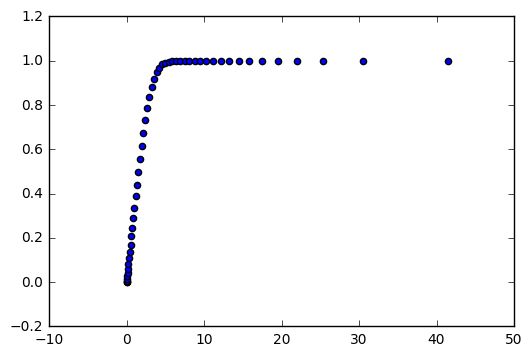

In [11]:
plt.scatter(y,U)

In [12]:
np.dot(D3,U) + U*np.dot(D2,U)

array([  1.92071945e+04,   6.33982194e+03,  -1.30521589e+03,
         5.55453656e+02,  -3.06525785e+02,   1.93661150e+02,
        -1.33004828e+02,   9.66123697e+01,  -7.31280903e+01,
         5.70051396e+01,  -4.55765015e+01,   3.70295786e+01,
        -3.06660568e+01,   2.55628032e+01,  -2.17070130e+01,
         1.83765723e+01,  -1.59161013e+01,   1.35792559e+01,
        -1.19640281e+01,   1.02254099e+01,  -9.14570082e+00,
         7.80511776e+00,  -7.05489587e+00,   6.02447281e+00,
        -5.44926948e+00,   4.69261064e+00,  -4.19417675e+00,
         3.66466426e+00,  -3.21969668e+00,   2.83828585e+00,
        -2.46789523e+00,   2.16570822e+00,  -1.87553064e+00,
         1.62621221e+00,  -1.39844529e+00,   1.19591046e+00,
        -1.01435228e+00,   8.52266534e-01,  -7.07887748e-01,
         5.79779181e-01,  -4.66700613e-01,   3.67592792e-01,
        -2.81555055e-01,   2.07828405e-01,  -1.45783413e-01,
         9.49149212e-02,  -5.48509149e-02,   2.54036251e-02,
        -6.78567725e-03,

# Comparing with my MATLAB script for makeSystem

In [3]:
from scipy.io import savemat
N = 127; Re=186.; a=2.5; b=20./3.

statInst = ops.statComp(N=N, Re=Re, a=a, b=b, covMat = np.identity(3*N))

Aphi = statInst.dynamicsMat(a=statInst.a, b=statInst.b)
Cphi = statInst.velVor2primitivesMat(a=statInst.a, b=statInst.b)

Delta = statInst.D2 - (a**2 + b**2) * np.identity(N)
savemat('testMatrices127laika.mat', {
       'Aphip':Aphi, 'Cphip':Cphi,
        'D1p': statInst.D1, 'D2p': statInst.D2, 'D4p': statInst.D4,
        'N': N, 'Re': Re, 'a':a, 'b':b, 
        'Up': statInst.U, 'dUp': statInst.dU, 'd2Up': statInst.d2U, 
        'Deltap': Delta})


Using parameters Re=186, alfa=46.5, kapa=0.61, N=127
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 2.5 6.666666666666667 186.0


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")
